## Visualize Track results

In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.segment import datasets
import livecell_tracker.segment
from livecell_tracker import segment
import livecell_tracker.core.utils
from tqdm import tqdm

seg_path = r""".\notebook_results\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched"""
label_seg_imgs = segment.datasets.LiveCellImageDataset(seg_path, ext="png")
dir_path = Path(
    r"..\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
raw_imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="png")


288 png img file paths loaded: 
288 png img file paths loaded: 


### load bbox paths

In [2]:
import json
_track_bbs_path = r"..\cxa-data\test_data\sort_track\max_age-5_min_hit-2_detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json"
with open(_track_bbs_path, "r") as in_f:
    json_in = json.load(in_f)
type(json_in[0][0][0])

int

In [3]:
all_track_bbs = [np.array(track_bbs, dtype=int) for track_bbs in json_in]


In [4]:
all_track_bbs[0].shape


(27, 5)

### Manually check bboxes  
 - be careful: coordinates of numpy/skimage/cv2/pixel/rowCol/bbox

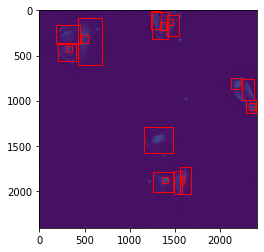

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

idx = 2
bboxes = all_track_bbs[idx]
fig, ax = plt.subplots()
ax.imshow(raw_imgs[idx])
for bbox in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (bbox[1], bbox[0]),
        (bbox[3] - bbox[1]),
        (bbox[2] - bbox[0]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
# plt.show()


Add information to SingleCellTrajectory

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic, single_cell

id_to_sc_trajs = {}
for timeframe, objects in enumerate(all_track_bbs):
    for obj in objects:
        track_id = obj[-1]
        if not (track_id in id_to_sc_trajs):
            new_traj = SingleCellTrajectory(raw_imgs, track_id=track_id)
            id_to_sc_trajs[track_id] = new_traj
        # print("obj: ", obj)
        # print("timeframe: {}, track_id: {}, bbox: {}".format(timeframe, track_id, obj))
        sc = SingleCellStatic(
            timeframe, bbox=np.array(obj[:4]).copy(), img_dataset=raw_imgs
        )  # final column is track_id, ignore as we only need bbox here

        _traj = id_to_sc_trajs[track_id]
        _traj.add_timeframe_data(timeframe, sc)


42


array([1816, 1575, 1912, 1607])

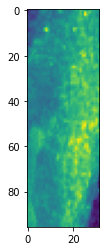

In [7]:
# sorted_trajs = sorted(list(id_to_sc_trajs.values()), key=lambda x: x.get_timeframe_span_length(), reverse=True)
_id = 29
print(id_to_sc_trajs[_id])
print(id_to_sc_trajs[_id].get_timeframe_span_length())
id_to_sc_trajs[_id].get_single_cell(15).show()
id_to_sc_trajs[_id].get_single_cell(15).bbox


In [9]:
%matplotlib widget
from typing import List
from livecell_tracker.track.movie import generate_single_trajectory_movie
output_path = Path("./track_tmp")
output_path.mkdir(exist_ok=True)

sorted_trajs = sorted(list(id_to_sc_trajs.values()), key=lambda x: x.get_timeframe_span_length(), reverse=True)
for traj in sorted_trajs:
    print("len:", traj.get_timeframe_span_length())
    generate_single_trajectory_movie(
        traj, raw_imgs, save_path=output_path / "track{}_len{}.avi".format(traj.track_id, traj.get_timeframe_span_length())
    )
    traj.to_json(path=output_path/"track_{}.json".format(traj.track_id))
    plt.close("all")


len: 287
saving to: track_tmp\track4_len287.avi...
len: 282
